In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random

from torch.utils.data import DataLoader, ChainDataset
from dataset import LargeDataset, RandomTurn

data = LargeDataset.load('../products/json/data.json', path='../resources/')

random.seed(0)
random.shuffle(data)

trainset = RandomTurn(LargeDataset(data[:350], transform='tensor', color='jitter', shuffle=True))
validset_0 = LargeDataset(data[350:400], transform='tensor', shuffle=True)
validset_1 = LargeDataset(data[350:400], transform='tensor', color='jitter', shuffle=True)

print('Training size = {}'.format(len(trainset)))
print('Validation size = {}'.format(len(validset_0)))

Training size = 29307
Validation size = 5314


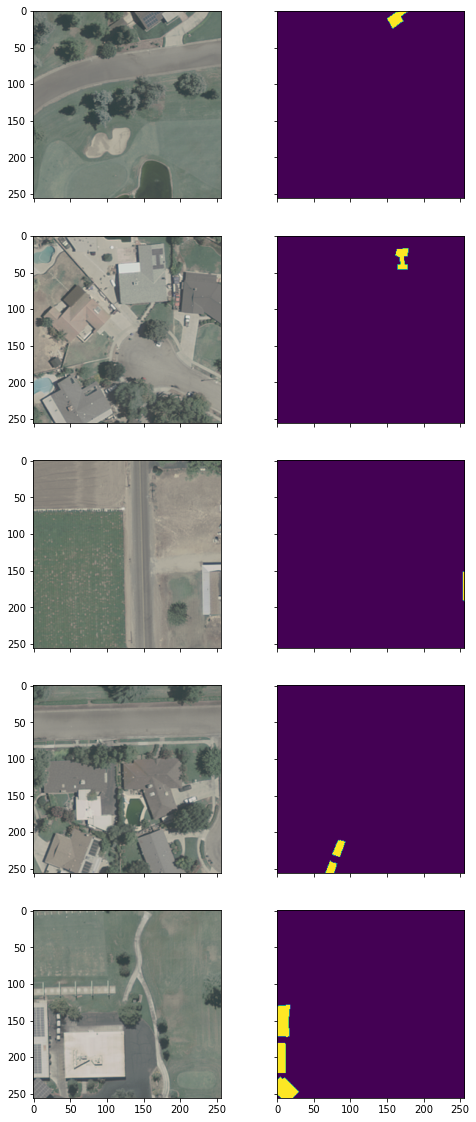

In [3]:
from torch.utils.data import DataLoader
from plots import plot_alongside

trainloader = DataLoader(trainset, batch_size=5)
validloader_0 = DataLoader(validset_0, batch_size=5)
validloader_1 = DataLoader(validset_1, batch_size=5)

for inputs, targets in trainloader:
    break

plot_alongside(inputs, targets)

In [4]:
import torch
from torchsummary import summary
from models import UNet

model = UNet(3, 1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.load_state_dict(torch.load('../products/models/unet_032.pth', map_location=device))

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14          [-1, 128,

In [5]:
import train
import numpy as np
from criterions import DiceLoss, TP, TN, FP, FN

metrics = train.eval(model, validloader_0, [DiceLoss(), TP(), TN(), FP(), FN()])

print('DiceLoss, TP, TN, FP, FN =', np.mean(metrics, axis=0), '+-', np.std(metrics, axis=0))

DiceLoss, TP, TN, FP, FN = [2.66717893e-01 2.69039641e+03 3.23564722e+05 3.09611801e+02
 1.05361864e+03] +- [1.93434896e-01 4.63537096e+03 5.83249478e+03 3.72074478e+02
 1.85109927e+03]


In [6]:
import train
import numpy as np
from criterions import DiceLoss, TP, TN, FP, FN

metrics = train.eval(model, validloader_1, [DiceLoss(), TP(), TN(), FP(), FN()])

print('DiceLoss, TP, TN, FP, FN =', np.mean(metrics, axis=0), '+-', np.std(metrics, axis=0))

DiceLoss, TP, TN, FP, FN = [2.98926849e-01 2.54952209e+03 3.23607018e+05 2.67315795e+02
 1.19449296e+03] +- [2.18669100e-01 4.56107710e+03 5.76471155e+03 3.48002627e+02
 1.90687582e+03]


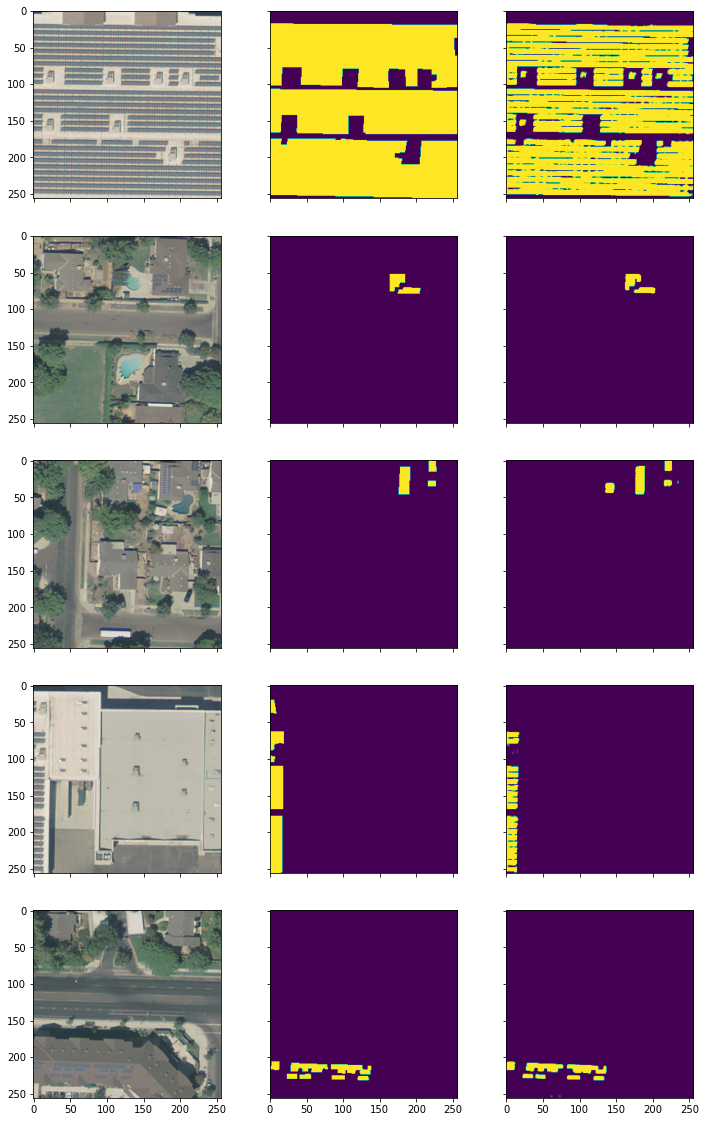

In [9]:
model.eval()

with torch.no_grad():
    for inputs, targets in validloader_0:
        break

    inputs = inputs.to(device)
    targets = targets.to(device)
    outputs = model(inputs)

plot_alongside(
    inputs.cpu(),
    targets.cpu(),
    outputs.cpu()
)